In [1]:
from ihpo.experiments import BenchmarkExperiment
from ihpo.benchmarks import BenchmarkFactory
from ihpo.optimizers import OptimizerFactory

ModuleNotFoundError: No module named 'ihpo'

In [ ]:
benchmark_name = 'jahs'
benchmark_config = {}
optimizer_name = 'pc'
optimizer_config = {}

benchmark = BenchmarkFactory.get_benchmark(benchmark_name, 
                                                benchmark_config)
optimizer = OptimizerFactory.get_optimizer(optimizer_name, optimizer_config)

In [ ]:
optimizer.optimize(ask_at=[5, 15, 50])

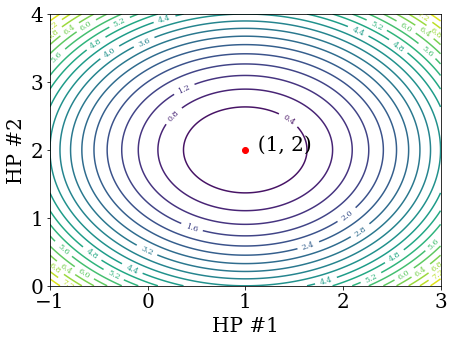

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20, 'font.family':'serif', "text.latex.preamble": r"\usepackage{amssymb}"})

# Define the function
def f(x, y):
    return (x - 1)**2 + (y - 2)**2

# Create a grid of x and y values
x = np.linspace(-1, 3, 400)
y = np.linspace(0, 4, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Create the contour plot
plt.figure(figsize=(7, 5))
contour = plt.contour(X, Y, Z, 20, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)
#plt.colorbar(contour)

# Highlight the minimum point
plt.plot(1, 2, 'ro', linewidth=100)  # Minimum point (1, 2)
plt.text(1, 2, '  (1, 2)', fontsize=20, ha='left')

# Add labels and title
plt.xlabel('HP #1')
plt.ylabel('HP #2')
#plt.title('Hyperparameter Optimization')

# Show the plot
plt.savefig('./hpo.pdf', bbox_inches='tight')
plt.show()


In [381]:
from spn.algorithms.LearningWrappers import learn_mspn, learn_parametric
from spn.algorithms.Sampling import sample_instances
from spn.structure.StatisticalTypes import MetaType
from spn.structure.leaves.histogram.Histograms import Histogram
from spn.structure.leaves.parametric.Parametric import Gaussian, Bernoulli, Categorical, create_parametric_leaf
from spn.structure.Base import Context, get_nodes_by_type, Sum, assign_ids
from spn.algorithms.stats.Moments import ConditionalMoment
from spn.algorithms.Condition import condition
from spn.algorithms.MPE import mpe
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

In [2]:
search_space_definition = {
    'Activation': {
        'type': MetaType.DISCRETE,
    },
    'LearningRate': {
        'type': MetaType.REAL,
        'min': 1e-3,
        'max': 1.0,
        'dtype': 'float'
    },
    'N': {
        'type': MetaType.DISCRETE,
    },
    'Op1': {
        'type': MetaType.DISCRETE,
    },
    'Op2': {
        'type': MetaType.DISCRETE,
    },
    'Op3': {
        'type': MetaType.DISCRETE,
    },
    'Op4': {
        'type': MetaType.DISCRETE,
    },
    'Op5': {
        'type': MetaType.DISCRETE,
    },
    'Op6': {
        'type': MetaType.DISCRETE,
    },
    'Resolution': {
        'type': MetaType.REAL,
        'min': 0.0,
        'max': 1.0,
        'dtype': 'float'
    },
    #'Resolution': {
    #    'type': MetaType.DISCRETE,
    #    'allowed': self.config_space['Resolution']
    #},
    'TrivialAugment': {
        'type': MetaType.BINARY,

    },
    'W': {
        'type': MetaType.DISCRETE,

    },
    'WeightDecay': {
        'type': MetaType.REAL,
        'min': 1e-5,
        'max': 1e-2,
        'dtype': 'float'
    },
    'epoch': {
        'type': MetaType.DISCRETE,

    }
}

In [4]:
#df = pd.read_csv('./data/toy_branin_skoptbo/toy_cifar10_09-25-2024_22:21:08_2195.csv', index_col=0)
df = pd.read_csv('./data/hpob_5527_31_optunabo/hpob_5527:31_09-04-2024_07:47:07_2195.csv', index_col=0)
y = df['test_performance'].to_numpy()
#X = df[['x_1', 'x_2']].to_numpy()
X = df[['_cost', 'degree', 'degree.na', 'gamma', 'gamma.na']].to_numpy()
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [467]:
df = pd.read_csv('./data/logs_v2/jahs_cifar10_pc/jahs_cifar10_02-12-2024_09:32:57.csv', index_col=0)
y = df['test_performance'].to_numpy()
exclude = ['train_performance', 'val_performance', 'test_performance', 'cost', 'iter', 'train_loss', 'val_loss', 'test_loss', 'optim_cost', 'epochs']
real_cols = ['LearningRate', 'Resolution', 'WeightDecay']
cols = [c for c in df.columns if c not in exclude]
df['TrivialAugment'] = df['TrivialAugment'].astype(np.int32)
le = LabelEncoder()
df['Activation'] = le.fit_transform(df['Activation'].to_numpy())
# for each discrete column, we fit a KDE over corresponding targets
# then we sample from the fitted KDE to obtain a continuous representation of each discrete variable value
#for rc in df.columns:
#    if rc not in real_cols and rc not in exclude:
#       df[rc] += np.random.uniform(-0.25, 0.25, df.shape[0])
        #for u in np.unique(df[rc]):
        #    targets = df[df[rc] == u]['test_performance']
        #    kde = KernelDensity(kernel='gaussian').fit(targets.to_numpy().reshape(-1, 1))
        #    cluster_samples = kde.sample(len(targets)).flatten()
        #    df.loc[df[rc] == u, rc] = cluster_samples
ctxt_types = [search_space_definition[c]['type'] for c in cols]
X = df[cols].to_numpy()
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#X_train = scaler_x.fit_transform(X_train)
#y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
#X_test = scaler_x.transform(X_test)
#y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [468]:
ctxt = Context(ctxt_types + [MetaType.REAL])
X_joint = np.hstack((X_train, y_train.reshape(-1, 1)))
ctxt.add_domains(X_joint)
spn = learn_mspn(X_joint, ctxt, min_instances_slice=10, threshold=0.4, n_clusters=2)

/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will

In [471]:
ctxt = Context(ctxt_types + [MetaType.REAL])
X_joint = np.hstack((X_train, y_train.reshape(-1, 1)))
ctxt.add_domains(X_joint)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_joint)
labels = kmeans.labels_
spns = []
for l in np.unique(labels):
    idx = np.argwhere(labels == l).flatten()
    data = X_joint[idx]
    spn = learn_mspn(X_joint, ctxt, min_instances_slice=10, threshold=0.4, n_clusters=2, standardize=False)
    #spn = learn_parametric(data, ctxt, min_instances_slice=10, threshold=0.4)
    spns.append(spn)
sum = Sum()
scope = list(set().union(*[set(n.scope) for n in spns]))
sum.scope = scope
weights = []
for l in np.unique(labels):
    idx = np.argwhere(labels == l).flatten()
    weights.append(len(idx))
weights = np.array(weights) / np.sum(weights)
sum.weights = weights
sum.children = spns
spn = assign_ids(sum)

/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will

In [231]:
##############################################################
# TODO: test how good fit is when we treat everything as Gaussian!!
##############################################################
params = [Gaussian] * (X_train.shape[1] + 1)
meta_types = [MetaType.REAL] * (X_train.shape[1] + 1)
ctxt = Context(meta_types=meta_types, parametric_types=params)
X_joint = np.hstack((X_train, y_train.reshape(-1, 1)))
ctxt.add_domains(X_joint)
#spn = learn_mspn(X_joint, ctxt, min_instances_slice=40, threshold=0.1, n_clusters=3, standardize=False)
spn = learn_parametric(X_joint, ctxt, min_instances_slice=20, threshold=0.4)

/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.

In [408]:
params = [Gaussian] * (X_train.shape[1] + 1)
meta_types = [MetaType.REAL] * (X_train.shape[1] + 1)
ctxt = Context(meta_types=meta_types, parametric_types=params)
X_joint = np.hstack((X_train, y_train.reshape(-1, 1)))
ctxt.add_domains(X_joint)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_joint)
labels = kmeans.labels_
spns = []
for l in np.unique(labels):
    idx = np.argwhere(labels == l).flatten()
    data = X_joint[idx]
    #spn = learn_mspn(X_joint, ctxt, min_instances_slice=10, threshold=0.4, n_clusters=2, standardize=False)
    spn = learn_parametric(data, ctxt, min_instances_slice=10, threshold=0.4)
    spns.append(spn)
sum = Sum()
scope = list(set().union(*[set(n.scope) for n in spns]))
sum.scope = scope
weights = []
for l in np.unique(labels):
    idx = np.argwhere(labels == l).flatten()
    weights.append(len(idx))
weights = np.array(weights) / np.sum(weights)
sum.weights = weights
sum.children = spns
spn = assign_ids(sum)

/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.

In [514]:
evidence = np.hstack((X_test, np.repeat(np.nan, X_test.shape[0]).reshape(-1, 1)))
ev_dim = evidence.shape[1] - 1
#pc_preds = ConditionalMoment(spn, evidence, [ev_dim])

# perform monte carlo sampling

preds = []
for i in range(20):
    pc_preds = sample_instances(spn, evidence, np.random.RandomState(i))
    preds.append(pc_preds[:, -1].flatten())
pc_preds = np.array(preds).mean(axis=0)
#pc_preds = mpe(spn, evidence)[:, -1].flatten()

In [515]:
pc_r2 = r2_score(y_test, pc_preds.flatten())
pc_r2

0.5942774498114711

In [447]:
# Initialize the random forest regressor
rf = RandomForestRegressor(n_estimators=5, random_state=42, max_depth=4, min_samples_leaf=20)
#rf = DecisionTreeRegressor(max_depth=5, min_samples_leaf=3)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model using R^2 score
r2 = r2_score(y_test, y_pred)
r2

0.715509161516809

In [513]:
weights = []
spns = []
for est in rf.estimators_:
    leaf_idx = est.apply(X_train)
    tree_weights = []
    tree_spns = []
    for u in np.unique(leaf_idx):
        data_idx = np.argwhere(leaf_idx == u).flatten()
        subset = X_joint[data_idx]
        leaf_spn = learn_mspn(X_joint, ctxt, min_instances_slice=3, threshold=0.4, n_clusters=2, standardize=False)
        tree_spns.append(leaf_spn)
        tree_weights.append(subset.shape[0])

    weights.append(1)
    tree_sum = Sum()
    scope = tree_spns[0].scope
    tree_sum.scope = scope
    tree_weights = np.array(tree_weights) / np.sum(tree_weights)
    tree_sum.weights = tree_weights
    tree_sum.children = tree_spns
    tree_spn = assign_ids(tree_sum)
    spns.append(tree_spn)


sum = Sum()
scope = spns[0].scope
sum.scope = scope
weights = np.array(weights) / np.sum(weights)
sum.weights = weights
sum.children = spns
spn = assign_ids(sum)

/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will

In [479]:
np.abs((y_pred - y_test)).mean()

46.68354905474456

In [377]:
np.abs((pc_preds - y_test)).mean()

0.5512321147324658

In [298]:
(y_pred - y_test).max()

2.761592799037804

In [299]:
(pc_preds - y_test).max()

2.6064504301802014

In [114]:
from spn.algorithms.Statistics import get_structure_stats_dict

In [282]:
get_structure_stats_dict(spn)

{'nodes': 6436,
 'params': 12465,
 'edges': 6435,
 'layers': 4,
 'count_per_type': {spn.structure.Base.Sum: 4,
  spn.structure.Base.Product: 402,
  spn.structure.leaves.parametric.Parametric.Gaussian: 6030}}

In [283]:
def ranking_accuracy(y_pred, y_true):
    gt_idx = np.argsort(y_true).flatten()
    pred_idx = np.argsort(y_pred).flatten()
    matches = gt_idx == pred_idx
    return (np.sum(matches) / len(gt_idx))

In [300]:
ranking_accuracy(pc_preds.flatten(), y_test)

0.006666666666666667

In [301]:
ranking_accuracy(y_pred, y_test)

0.0016666666666666668

In [243]:
import matplotlib.pyplot as plt

(array([ 1.,  9., 19., 26., 28., 38., 34., 23., 17., 23., 11.,  8.,  9.,
        14., 13., 18., 16., 19., 18., 41., 32., 31., 39., 29., 20., 21.,
        17., 14., 10.,  2.]),
 array([-1.69623091, -1.58762486, -1.47901881, -1.37041276, -1.26180671,
        -1.15320066, -1.04459461, -0.93598856, -0.82738252, -0.71877647,
        -0.61017042, -0.50156437, -0.39295832, -0.28435227, -0.17574622,
        -0.06714017,  0.04146588,  0.15007193,  0.25867798,  0.36728402,
         0.47589007,  0.58449612,  0.69310217,  0.80170822,  0.91031427,
         1.01892032,  1.12752637,  1.23613242,  1.34473847,  1.45334451,
         1.56195056]),
 <BarContainer object of 30 artists>)

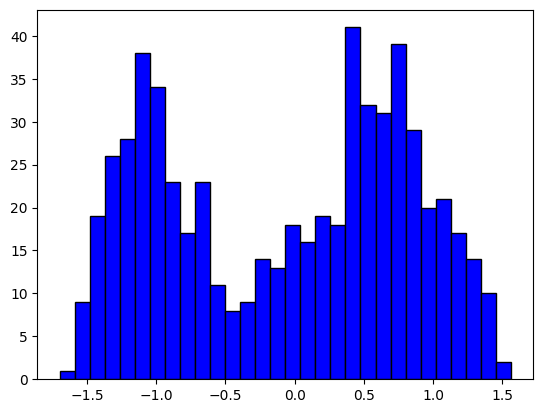

In [378]:
plt.hist(pc_preds, bins=30, color='blue', edgecolor='black')

(array([ 6.,  8., 18., 20., 12., 24., 29., 27., 11., 14., 15., 18., 25.,
        15., 19., 20., 26., 23., 24., 30., 35., 32., 25., 18., 25., 18.,
        21., 15., 15., 12.]),
 array([-1.74662354, -1.63686786, -1.52711217, -1.41735649, -1.3076008 ,
        -1.19784512, -1.08808943, -0.97833375, -0.86857806, -0.75882238,
        -0.64906669, -0.53931101, -0.42955532, -0.31979964, -0.21004395,
        -0.10028827,  0.00946742,  0.1192231 ,  0.22897878,  0.33873447,
         0.44849015,  0.55824584,  0.66800152,  0.77775721,  0.88751289,
         0.99726858,  1.10702426,  1.21677995,  1.32653563,  1.43629132,
         1.546047  ]),
 <BarContainer object of 30 artists>)

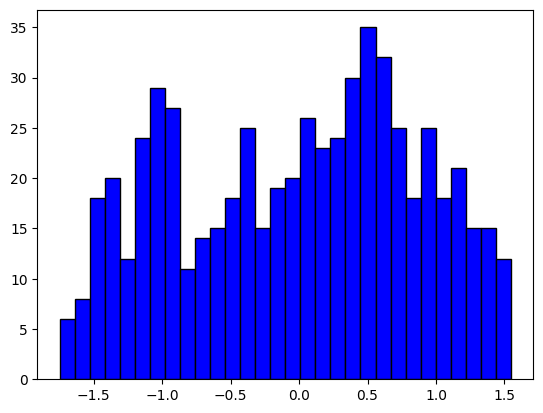

In [379]:
plt.hist(y_pred, bins=30, color='blue', edgecolor='black')

(array([11., 21., 23., 21.,  9., 13., 19., 14., 21., 26., 15., 15., 15.,
        17., 21., 20., 19., 30., 12., 33., 26., 19., 28., 33., 26., 17.,
        23., 26., 16., 11.]),
 array([-1.92202805, -1.80051258, -1.6789971 , -1.55748162, -1.43596614,
        -1.31445066, -1.19293519, -1.07141971, -0.94990423, -0.82838875,
        -0.70687327, -0.58535779, -0.46384232, -0.34232684, -0.22081136,
        -0.09929588,  0.0222196 ,  0.14373507,  0.26525055,  0.38676603,
         0.50828151,  0.62979699,  0.75131246,  0.87282794,  0.99434342,
         1.1158589 ,  1.23737438,  1.35888985,  1.48040533,  1.60192081,
         1.72343629]),
 <BarContainer object of 30 artists>)

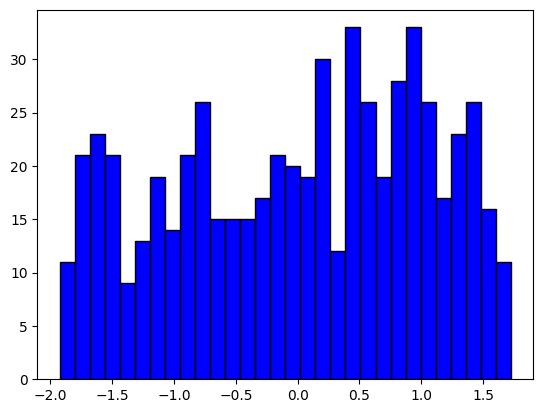

In [380]:
plt.hist(y_test, bins=30, color='blue', edgecolor='black')

In [411]:
params = [Gaussian] * (X_train.shape[1] + 1)
meta_types = [MetaType.REAL] * (X_train.shape[1] + 1)
ctxt = Context(meta_types=meta_types, parametric_types=params)
X_joint = np.hstack((X_train, y_train.reshape(-1, 1)))
ctxt.add_domains(X_joint)

# do bootstrapping
ensemble_spns = []
ensemble_weights = []
for _ in range(10):
    ridx = np.random.choice(np.arange(X_joint.shape[0]), int(0.6*X_joint.shape[0]))
    subset = X_joint[ridx]
    ensemble_weights.append(subset.shape[0])
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(subset)
    labels = kmeans.labels_
    spns = []
    for l in np.unique(labels):
        idx = np.argwhere(labels == l).flatten()
        data = subset[idx]
    #spn = learn_mspn(X_joint, ctxt, min_instances_slice=40, threshold=0.1, n_clusters=3, standardize=False)
        spn = learn_parametric(data, ctxt, min_instances_slice=10, threshold=0.4)
        spns.append(spn)
    sum = Sum()
    scope = list(set().union(*[set(n.scope) for n in spns]))
    sum.scope = scope
    weights = []
    for l in np.unique(labels):
        idx = np.argwhere(labels == l).flatten()
        weights.append(len(idx))
    weights = np.array(weights) / np.sum(weights)
    sum.weights = weights
    sum.children = spns
    spn = assign_ids(sum)
    ensemble_spns.append(spn)

sum = Sum()
scope = ensemble_spns[0].scope
sum.scope = scope
weights = np.array(ensemble_weights) / np.sum(ensemble_weights)
sum.weights = weights
sum.children = ensemble_spns
spn = assign_ids(sum)

/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.

In [11]:
from spn.algorithms.LearningWrappers import learn_mspn, learn_parametric
from spn.algorithms.Sampling import sample_instances
from spn.structure.StatisticalTypes import MetaType
from spn.structure.leaves.histogram.Histograms import Histogram
from spn.structure.leaves.parametric.Parametric import Gaussian, Bernoulli, Categorical, create_parametric_leaf
from spn.structure.Base import Context, get_nodes_by_type, Sum, assign_ids, Product
from spn.algorithms.stats.Moments import ConditionalMoment
from spn.algorithms.Condition import condition
from spn.algorithms.MPE import mpe
from spn.algorithms.Marginalization import marginalize
from spn.algorithms.Inference import log_likelihood
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

In [54]:
np.random.seed(123)
train_data = np.c_[np.r_[np.random.normal(5, 1, (500, 2)), np.random.normal(10, 1, (500, 2))],
                   np.r_[np.zeros((500, 1)), np.ones((500, 1))]]

In [55]:
data = train_data[:, :2]
ctxt = Context([MetaType.REAL, MetaType.REAL])
ctxt.add_domains(data)
spn = learn_mspn(data, ctxt)

/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [56]:
node = Categorical(p=[0.5, 0.5], scope=[2])
prod = Product(children=[node, spn])
prod.scope=[2, 0, 1]
prod = assign_ids(prod)

In [57]:
indata = np.array([np.nan]*3*10).reshape(10, -1)
sample_instances(prod, indata, rand_gen=np.random.RandomState(123))

array([[11.52635811, 11.12425216,  1.        ],
       [ 3.56759845,  4.79743315,  1.        ],
       [10.06245001,  9.35367847,  1.        ],
       [10.33731389,  9.97536072,  1.        ],
       [ 8.82383153, 12.15616803,  1.        ],
       [ 4.76441937,  4.49979606,  0.        ],
       [ 9.56845899, 10.0756402 ,  0.        ],
       [ 4.75768836,  4.79863241,  0.        ],
       [ 9.84000764, 10.32491805,  0.        ],
       [ 4.91142812,  6.2577333 ,  1.        ]])

In [58]:
marg = marginalize(prod, [1, 2])
node2 = Gaussian(mean=0, stdev=1., scope=[3])
prod2 = Product(children=[node2, marg])
prod2.scope=[1, 2, 3]
prod2 = assign_ids(prod2)

In [59]:
indata = np.array([np.nan]*4*10).reshape(10, -1)
data = sample_instances(prod2, indata, rand_gen=np.random.RandomState(123))
data = data[:, [1,2,3]]

In [60]:
data

array([[11.12425216,  0.        ,  1.0040539 ],
       [ 5.25346539,  0.        ,  0.3861864 ],
       [ 9.35367847,  0.        ,  0.73736858],
       [ 9.97536072,  0.        ,  1.49073203],
       [12.15616803,  0.        , -0.93583387],
       [ 3.7344017 ,  0.        ,  1.17582904],
       [10.0756402 ,  0.        , -1.25388067],
       [ 4.51418513,  1.        , -0.6377515 ],
       [10.32491805,  1.        ,  0.9071052 ],
       [ 4.77210432,  1.        , -1.4286807 ]])

In [61]:
ctxt = Context([MetaType.REAL, MetaType.DISCRETE, MetaType.REAL])
ctxt.add_domains(data)
spn = learn_mspn(data, ctxt)

In [62]:
indata = np.array([np.nan]*4*10).reshape(10, -1)
new_data = sample_instances(spn, indata, rand_gen=np.random.RandomState(123))
new_data

array([[ 9.9066787 ,  0.        ,  0.87533955,         nan],
       [ 5.2963295 ,  1.        ,  1.24295099,         nan],
       [ 4.97269909,  0.        ,  1.03728474,         nan],
       [ 9.11433493,  0.        ,  0.80709113,         nan],
       [10.03222594,  0.        ,  1.03397381,         nan],
       [ 7.52877004,  1.        , -0.62783249,         nan],
       [11.99416861,  0.        , -0.44290145,         nan],
       [ 9.84314331,  0.        , -0.9482282 ,         nan],
       [ 8.59401681,  0.        , -0.76711447,         nan],
       [ 6.95789899,  0.        ,  0.86534104,         nan]])

In [63]:
scope_mapping = {0: 1, 1:2, 2:3}
for node in get_nodes_by_type(spn):
    new_scope = []
    for s in node.scope:
        new_scope.append(scope_mapping[s])
    node.scope = new_scope

In [64]:
indata = np.array([np.nan]*4*10).reshape(10, -1)
new_data = sample_instances(spn, indata, rand_gen=np.random.RandomState(123))
new_data

array([[        nan,  9.9066787 ,  0.        ,  0.87533955],
       [        nan,  5.2963295 ,  1.        ,  1.24295099],
       [        nan,  4.97269909,  0.        ,  1.03728474],
       [        nan,  9.11433493,  0.        ,  0.80709113],
       [        nan, 10.03222594,  0.        ,  1.03397381],
       [        nan,  7.52877004,  1.        , -0.62783249],
       [        nan, 11.99416861,  0.        , -0.44290145],
       [        nan,  9.84314331,  0.        , -0.9482282 ],
       [        nan,  8.59401681,  0.        , -0.76711447],
       [        nan,  6.95789899,  0.        ,  0.86534104]])

In [1]:
def rosenbrock(x, c1, c2):
    result = -sum(c1[i] * (x[i+1] - x[i]**2)**2 + (c2[i] - x[i])**2 for i in range(len(x) - 1))
    return result

In [2]:
rosenbrock([1.88, 3.5], [100, 100], [1, 1])

-0.8927359999999982

In [6]:
rosenbrock([1.03, 1, 1.], [100, 100, 100], [1, 1, 1])

-0.3717809999999994

In [7]:
rosenbrock([1.03, 1, 1.], [100, 50, 100], [1, 3, 1])

-4.3717809999999995

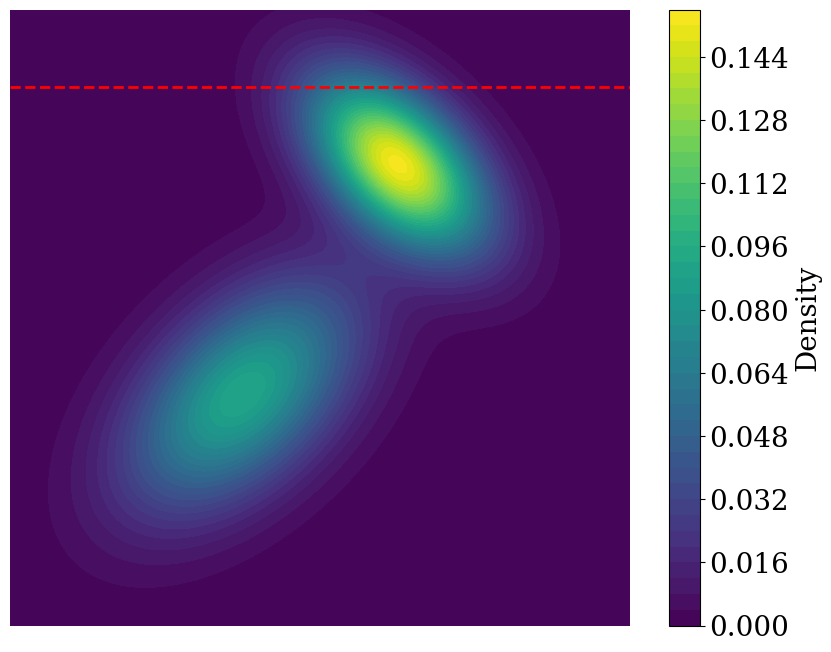

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

plt.rcParams.update({'font.size': 20, 'font.family':'serif'})

# Step 1: Define GMM parameters
means = [np.array([0, 0]), np.array([2, 3])]       # Means of the Gaussians
covariances = [np.array([[1, 0.5], 
                         [0.5, 1]]),     # Covariance matrices
               np.array([[0.6, -0.3], 
                         [-0.3, 0.6]])]
weights = [0.5, 0.5]                               # Mixing weights

# Step 2: Create a grid of points
x = np.linspace(-3, 5, 100)
y = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))  # Shape (100, 100, 2)

# Step 3: Evaluate the Gaussian mixture model
Z = np.zeros(X.shape)
for mean, cov, weight in zip(means, covariances, weights):
    rv = multivariate_normal(mean, cov)
    Z += weight * rv.pdf(pos)  # Weighted sum of Gaussians

# Step 4: Create the contour plot
plt.figure(figsize=(10, 8))

# Filled contour plot
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.axhline(4., color='red', linestyle='--', linewidth=2)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label('Density')

# Labels and title
#plt.title('Contour Plot of a 2D Gaussian Mixture Model')
plt.xlabel('Hyperparameter')
plt.ylabel('Score')
plt.grid(False)
plt.axis('off')
plt.savefig('./gmm.pdf')


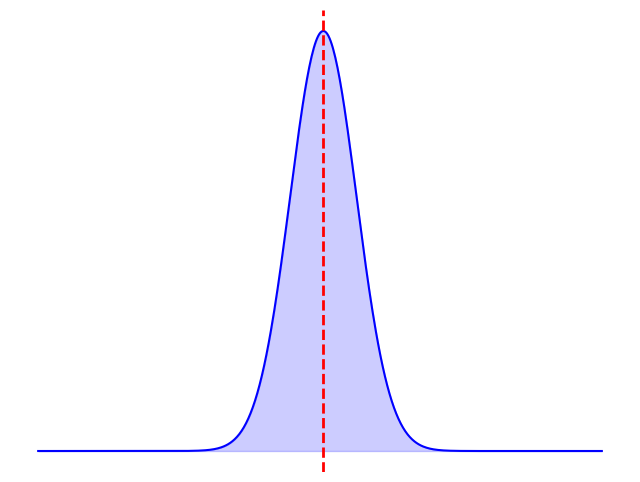

In [61]:
from scipy.stats import norm
# Define parameters of the Gaussian
mean = 1.9
std_dev = 0.25

# Create a range of x values around the mean
x = np.linspace(-0.25, 4, 500)

# Compute the Gaussian density
density = norm.pdf(x, loc=mean, scale=std_dev)


# Plot the Gaussian density
plt.figure(figsize=(8, 6))
plt.plot(x, density, color='blue')
plt.fill_between(x, density, color='blue', alpha=0.2)

#samples = [[1.5, 0], [2.8, 0]]
#for x, y in samples:
#    plt.scatter(x, y, s=200, color='green')
#
#starts, ends = [1., 2.3], [2., 3.3]
#for s, e in zip(starts, ends):
#    x_range = np.linspace(s, e, 500)
#    y_range = np.full_like(x_range, 0)
#    plt.plot(x_range, y_range, color='black', linestyle='dotted', linewidth=3)



plt.axvline(1.9, color='red', linestyle='--', linewidth=2 )
#plt.title('1D Gaussian Density')
plt.xlabel('Hyperparameter')
plt.ylabel('Density')
plt.grid(False)
plt.axis('off')
#plt.legend()
plt.savefig('guassian.pdf')

In [71]:
import numpy as np

import torch
from torch import nn
import matplotlib.pyplot as plt
import scipy

torch.set_default_tensor_type('torch.DoubleTensor')
torch.set_num_threads(1)

# --
# Helpers

class Encoder(nn.Module):
    """ NN for learning projection """
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=50):
        super().__init__()
        self._encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self._encoder(x)


class BLR:
    """ Bayesian linear regression """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta  = beta
    
    def fit(self, phi, y):
        
        S_inv_prior = self.alpha * torch.eye(phi.shape[1])
        S_inv       = S_inv_prior + self.beta * phi.t() @ phi
        S           = torch.inverse(S_inv)
        m           = self.beta * S @ phi.t() @ y
        
        self.S = S
        self.m = m
        return self
    
    def predict_with_nll(self, phi, y=None):
        mu  = phi @ self.m
        sig = 1 / self.beta + ((phi @ self.S) * phi).sum(dim=-1)
        if y is not None:
            nll = ((y - mu).pow(2).sum() / sig).mean() + sig.log().mean()
            return mu, sig, nll
        else:
            return mu, sig


# --
# Make datasets

def make_problems(num_problems):
    """ 
        Generate synthetic problems
        sin functions w/ different amplitude, phase and frequency + noise
    """
    problems = []
    for _ in range(num_problems):
        
        x = np.random.uniform(-5, 5, (10, 1))
        
        noise_std = 0.1
        amp       = np.random.uniform(0.1, 5.0)
        phase     = np.random.uniform(0, 3.14)
        freq      = np.random.uniform(0.999, 1.0)
        
        y = amp * np.sin(freq * x + phase)
        y += np.random.normal(0, noise_std, y.shape)
        
        problems.append([
            torch.Tensor(x),
            torch.Tensor(y),
        ])
    
    return problems

num_problems   = 30
train_problems = make_problems(num_problems=num_problems)

# --
# Setup model

encoder = Encoder()
alphas  = nn.Parameter(torch.zeros(num_problems)) # One alpha per problem
betas   = nn.Parameter(torch.zeros(num_problems)) # One beta per problem

params = list(encoder.parameters()) + [alphas, betas]
opt    = torch.optim.LBFGS(params, lr=0.1, max_iter=30)

# --
# Train

def _optimization_target():
    opt.zero_grad()
    
    total_nll, total_mse = 0, 0
    for idx, (X, y) in enumerate(train_problems):
        alpha, beta = 10 ** alphas[idx], 1 / 10 ** betas[idx]
        
        phi = encoder(X)
        
        blr = BLR(alpha=alpha, beta=beta)
        blr = blr.fit(phi, y)
        mu, sig, nll = blr.predict_with_nll(phi, y)
        total_nll += nll
        
        total_mse += ((mu - y) ** 2).mean()
    
    total_nll /= len(train_problems)
    total_mse /= len(train_problems)
    
    total_nll.backward()
    
    print(float(total_mse), float(total_nll))
    
    return float(total_nll)

opt.step(_optimization_target)


fig = plt.figure(figsize=(12,9))
idx = np.argsort(x.flatten().detach().numpy())
x_, y_, mu_, sig_ = x.flatten().detach().numpy(), y.flatten().detach().numpy(), mu.flatten().detach().numpy(), sig.flatten().detach().numpy()
plt.plot(x_[idx], mu_[idx], color='red')
plt.plot(x_[idx], y_[idx], color='blue', alpha=0.5)
plt.fill_between(x_[idx], mu_[idx] + sig_[idx], mu_[idx] - sig_[idx], color='red', alpha=0.2)
plt.show()

2.047637070149921 17.05903345988323
2.042352229381596 17.008396276535105
1.1176171839640827 8.74587058489061
0.9875374208554766 7.671406885124089
0.8882400616972957 6.88235752170681
0.7868331626962093 6.093904632836175
0.699095286551678 5.4214329110202355
0.6318858558196757 4.910811746110758
0.5723311302916952 4.4607661490557495
0.5189069309982081 4.0577939088561426
0.4701167547650514 3.689629790355797
0.42646149510353226 3.3593775688356575
0.3877761663533068 3.0657743488574343
0.3547978684885747 2.814139294992772
0.3259538791122448 2.5931860794683694
0.30024452046278594 2.3948464435719954
0.2759767066418927 2.2076520717985333
0.2529490769090598 2.028723878796712
0.23324608103027797 1.8763506527470513
0.21601970648778887 1.7424955762403476
0.199519430966871 1.6153557126294802
0.18371271997165053 1.4931750038353464
0.16894511079269256 1.3799916540137354
0.1549437984329621 1.2724881124330152
0.1411185248528414 1.1669688613330467
0.12681030948561975 1.0570844911550816
0.11168244979962719 

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

<Figure size 1200x900 with 0 Axes>

In [86]:
def _ei(blr, encoder, y_star):
    best_samples = []
    for j in range(3):
        eic_samples = np.random.uniform(-4, 4, size=(100,))
        phi = encoder(torch.from_numpy(eic_samples).reshape(-1, 1))
        mu, sig = blr.predict_with_nll(phi)
        mu, sig = mu.flatten().detach().numpy(), sig.flatten().detach().numpy()
        improve =  y_star - mu
        scaled = improve / sig
        cdf = scipy.stats.norm.cdf(scaled)
        pdf = scipy.stats.norm.pdf(scaled)
        exploit = improve * cdf
        explore = sig * pdf
        best = np.argsort(explore + exploit)
        best_samples.append(eic_samples[best[0]])
    return np.array(best_samples)

In [73]:
_ei(blr, encoder, y.detach().numpy().max())

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [90]:
class Objective:

    def __init__(self) -> None:
        self.noise_std = 0.1
        self.amp       = np.random.uniform(0.1, 5.0)
        self.phase     = np.random.uniform(0, 3.14)
        self.freq      = np.random.uniform(0.999, 1.0)

    def __call__(self, x):
        
        y = self.amp * np.sin(self.freq * x + self.phase)
        y += np.random.normal(0, self.noise_std, y.shape)
        return y
    

class ABLROptimier:

    def __init__(self, encoder) -> None:
        self.alphas  = nn.Parameter(torch.zeros(1)) # One alpha per problem
        self.betas   = nn.Parameter(torch.zeros(1)) # One beta per problem
        self.alpha, self.beta = 10 ** self.alphas, 1 / 10 ** self.betas

        self.opt    = torch.optim.LBFGS([self.alphas, self.betas], lr=0.1, max_iter=5)
        self.encoder = encoder
        self.blr =  BLR(alpha=self.alpha, beta=self.beta)

    def learn_blr(self):
        
        self.blr = self.blr.fit(self.phi, self.y_)
        mu, sig, nll = self.blr.predict_with_nll(self.phi, self.y_)
        #nll.backward()
        return float(nll)

    def bo(self, f):
        # draw and evaluate 3 random samples
        x = np.random.uniform(-4, 4, 3)
        y = f(x)

        for _ in range(3):
            self.x_ = torch.from_numpy(x).reshape(-1, 1)
            self.y_ = torch.from_numpy(y).reshape(-1, 1)
            self.phi = self.encoder(self.x_)

            self.opt.step(self.learn_blr)

            candidates = _ei(self.blr, self.encoder, y.max())

            new_y = f(candidates)
            x = np.concatenate((x, candidates), axis=0)
            y = np.concatenate((y, new_y), axis=0)

In [91]:
bo_optim = ABLROptimier(encoder)
f = Objective()
bo_optim.bo(f)

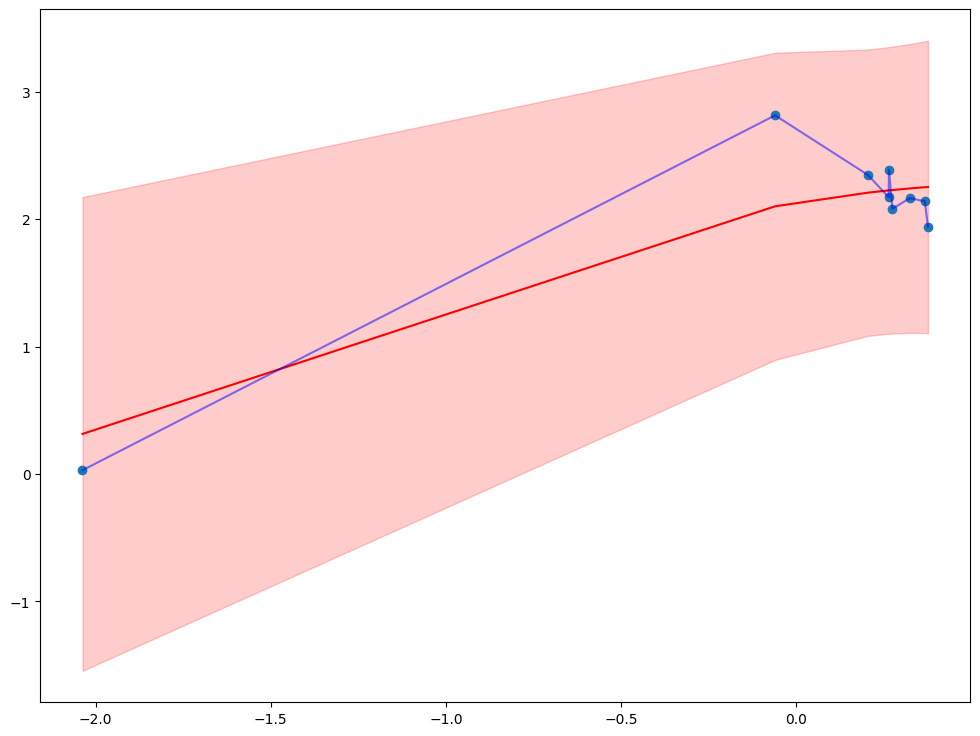

In [92]:
fig = plt.figure(figsize=(12,9))
x = bo_optim.x_.flatten().detach().numpy()
y = bo_optim.y_.flatten().detach().numpy()
idx = np.argsort(x)
mu, sig = bo_optim.blr.predict_with_nll(bo_optim.encoder(bo_optim.x_))
mu_, sig_ = mu.flatten().detach().numpy(), sig.flatten().detach().numpy()
plt.plot(x[idx], mu_[idx], color='red')
plt.plot(x[idx], y[idx], color='blue', alpha=0.5)
plt.fill_between(x[idx], mu_[idx] + sig_[idx], mu_[idx] - sig_[idx], color='red', alpha=0.2)
plt.scatter(x, y)
plt.show()

In [93]:
10**0.0045

1.0104155005282134

In [12]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
plt.rcParams.update({'font.size': 20, 'font.family':'serif', "text.latex.preamble": r"\usepackage{amssymb}"})

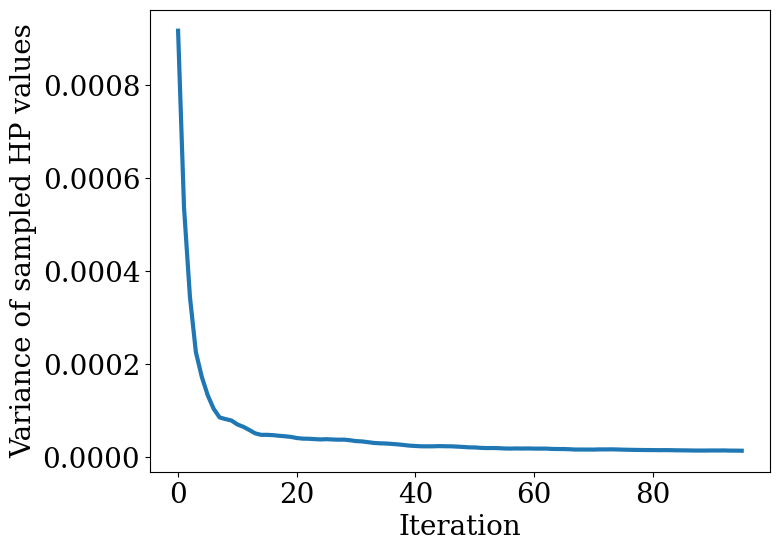

In [44]:
fig = plt.figure(figsize=(8, 6))
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_ys = []

for file in os.listdir('./data/new-exp/jahs_cifar10_pc/')[:20]:
    file_name = os.path.join('./data/new-exp/jahs_cifar10_pc/', file)
    df = pd.read_csv(file_name)
    lr = df['WeightDecay'].to_numpy().flatten()
    chunks = np.array_split(lr, len(lr) // 20)
    x_axis, y_axis = [], []
    for i, c in enumerate(chunks):
        std = c.std()
        x_axis.append(i)
        y_axis.append(std)
    
    # Apply moving average
    smoothed_y = moving_average(y_axis, window_size=5)
    
    smoothed_ys.append(smoothed_y)
smoothed_ys = np.array(smoothed_ys).mean(axis=0)
plt.plot(np.arange(0, len(smoothed_ys)), smoothed_ys, linewidth=3)
plt.xlabel('Iteration')
plt.ylabel('Variance of sampled HP values')
plt.savefig('./ihpo/utils/plots/iclr-rebuttal/jahs_cifar10_wd_exploration_exploitation.pdf')

In [45]:
import seaborn as sns

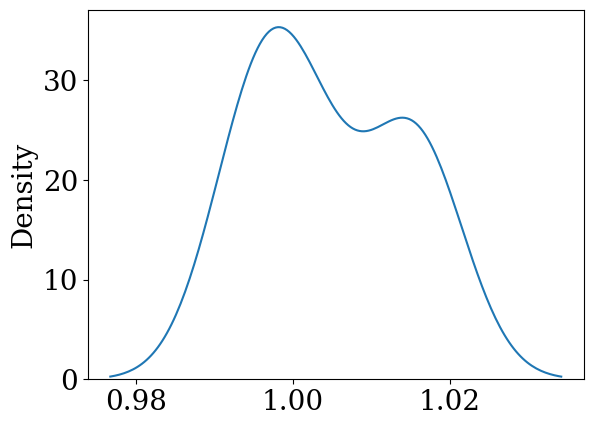

In [47]:
for file in os.listdir('./data/new-exp/jahs_cifar10_pibo/')[:1]:
    file_name = os.path.join('./data/new-exp/jahs_cifar10_pibo/', file)
    df = pd.read_csv(file_name)
    v = df['Resolution'].to_numpy().flatten()[:8]
    sns.kdeplot(v)

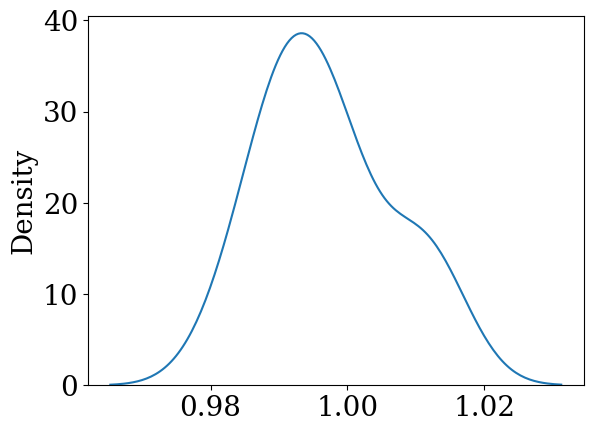

In [53]:
for file in os.listdir('./data/new-exp/jahs_cifar10_pc_int_early/')[:1]:
    file_name = os.path.join('./data/new-exp/jahs_cifar10_pc_int_early/', file)
    df = pd.read_csv(file_name)
    v = df['Resolution'].to_numpy().flatten()[100:113] + np.random.normal(0, 0.01, size=13)
    sns.kdeplot(v)

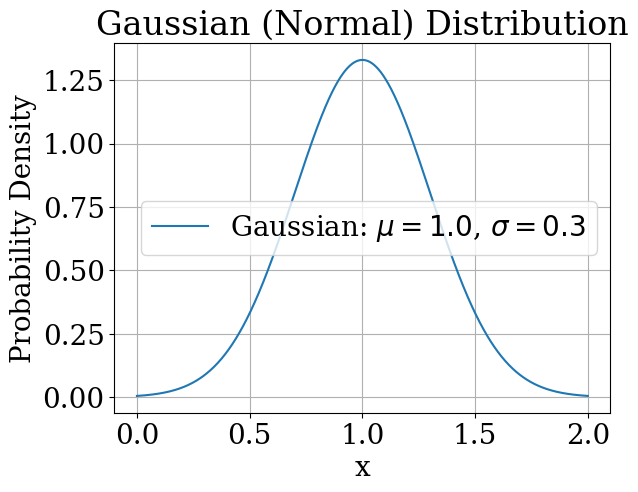

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the mean and standard deviation
mean = 1.
std_dev = 0.3

# Generate x values
x = np.linspace(0, 2, 1000)

# Compute the Gaussian (normal distribution) values
y = norm.pdf(x, mean, std_dev)

# Plot the Gaussian
plt.plot(x, y, label=f'Gaussian: $\mu={mean}$, $\sigma={std_dev}$')
plt.title("Gaussian (Normal) Distribution")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()


In [1]:
import pandas as pd

In [9]:
path = './benchmark_data/pd1/pd1_matched_phase1_results.jsonl'
with open(path, 'r') as fin:
      df1 = pd.read_json(fin, orient='records', lines=True)

path = './benchmark_data/pd1/pd1_unmatched_phase1_results.jsonl'
with open(path, 'r') as fin:
      df2 = pd.read_json(fin, orient='records', lines=True)

df = pd.concat((df1, df2))

In [ ]:
hps = ['hps.lr_hparams.decay_steps_factor', 'hps.lr_hparams.initial_value', 'hps.lr_hparams.power', 'hps.opt_hparams.momentum']
for d in df['dataset'].unique():
    print(d)
    img_df = df[df['dataset'] == d]
    img_df = img_df[img_df['status'] == 'done']
    #img_df[['hps.lr_hparams.initial_value', 'hps.lr_hparams.power', 'hps.opt_hparams.momentum', 'hps.lr_hparams.decay_steps_factor']].to_numpy()
    for h in hps:
        print(h)
        print(np.min(img_df[h].to_numpy()))
        print(np.max(img_df[h].to_numpy()))

In [35]:
df['hps.activation_fn'].unique()

array([None, 'tanh', 'relu'], dtype=object)

In [28]:
df['model'].unique()

array(['resnet', 'transformer', 'xformer_translate', 'max_pooling_cnn',
       'simple_cnn', 'wide_resnet'], dtype=object)

In [61]:
import os
tasks = []
for f in os.listdir('./benchmark_data/pd1/surrogates/'):
    tasks.append(f)
tasks

['lm1b_transformer_2048_None',
 'imagenet_resnet_256_None',
 'svhn_no_extra_wide_resnet_256_None',
 'cifar10_wide_resnet_2048_None',
 'fashion_mnist_max_pooling_cnn_256_relu',
 'imagenet_resnet_512_None',
 'mnist_simple_cnn_256_None',
 'mnist_max_pooling_cnn_2048_tanh',
 'mnist_max_pooling_cnn_256_relu',
 'mnist_simple_cnn_2048_None',
 'fashion_mnist_max_pooling_cnn_256_tanh',
 'svhn_no_extra_wide_resnet_1024_None',
 'fashion_mnist_max_pooling_cnn_2048_tanh',
 'uniref50_transformer_128_None',
 'fashion_mnist_max_pooling_cnn_2048_relu',
 'cifar100_wide_resnet_256_None',
 'translate_wmt_xformer_translate_64_None',
 'cifar100_wide_resnet_2048_None',
 'mnist_max_pooling_cnn_256_tanh',
 'cifar10_wide_resnet_256_None',
 'fashion_mnist_simple_cnn_256_None',
 'fashion_mnist_simple_cnn_2048_None',
 'mnist_max_pooling_cnn_2048_relu']

In [59]:
df[(df['dataset'] == 'lm1b') & (df['model'] == 'transformer') & (df['hps.batch_size'] == 2048)].columns.tolist()

['dataset',
 'model',
 'hparams',
 'model_shape',
 'trial_dir',
 'status',
 'hps.batch_norm_epsilon',
 'hps.batch_norm_momentum',
 'hps.batch_size',
 'hps.data_format',
 'hps.l2_decay_factor',
 'hps.l2_decay_rank_threshold',
 'hps.label_smoothing',
 'hps.lr_hparams.end_factor',
 'hps.lr_hparams.decay_steps_factor',
 'hps.lr_hparams.schedule',
 'hps.lr_hparams.initial_value',
 'hps.lr_hparams.power',
 'hps.model_dtype',
 'hps.num_filters',
 'hps.num_layers',
 'hps.opt_hparams.momentum',
 'hps.optimizer',
 'hps.rng_seed',
 'hps.use_shallue_label_smoothing',
 'hps.virtual_batch_size',
 'hps.input_shape',
 'hps.output_shape',
 'hps.train_size',
 'hps.valid_size',
 'epoch',
 'eval_time',
 'global_step',
 'learning_rate',
 'preemption_count',
 'steps_per_sec',
 'train/ce_loss',
 'train/denominator',
 'train/error_rate',
 'train_cost',
 'valid/ce_loss',
 'valid/denominator',
 'valid/error_rate',
 'study_dir',
 'hps.attention_dropout_rate',
 'hps.dropout_rate',
 'hps.emb_dim',
 'hps.mlp_dim',


In [37]:
PD1_TASKS = [
    ('cifar10', 'wide_resnet', 256, None),
    ('cifar10', 'wide_resnet', 2048, None),
    ('fashion_mnist', 'max_pooling_cnn', 256, 'relu'),
    ('fashion_mnist', 'max_pooling_cnn', 2048, 'relu'),
    ('fashion_mnist', 'max_pooling_cnn', 256, 'tanh'),
    ('fashion_mnist', 'max_pooling_cnn', 2048, 'tanh'),
    ('fashion_mnist', 'simple_cnn', 256, None),
    ('fashion_mnist', 'simple_cnn', 2048, None),
    ('imagenet', 'resnet', 256, None),
    ('imagenet', 'resnet', 512, None),
    ('lm1b', 'transformer', 2048, None),
    ('mnist', 'max_pooling_cnn', 256, 'relu'),
    ('mnist', 'max_pooling_cnn', 2048, 'relu'),
    ('mnist', 'max_pooling_cnn', 256, 'tanh'),
    ('mnist', 'max_pooling_cnn', 2048, 'tanh'),
    ('mnist', 'simple_cnn', 256, None),
    ('mnist', 'simple_cnn', 2048, None),
    ('svhn_no_extra', 'wide_resnet', 256, None),
    ('svhn_no_extra', 'wide_resnet', 1024, None),
    ('translate_wmt', 'xformer_translate', 64, None),
    ('uniref50', 'transformer', 128, None),
]

In [50]:
for ds, model, bs, act_fn in PD1_TASKS:
    if act_fn is not None:
        fdf = df[(df['dataset'] == ds) & (df['model'] == model) & (df['hps.batch_size'] == bs) & (df['hps.activation_fn'] == act_fn)]
    else:
        fdf = df[(df['dataset'] == ds) & (df['model'] == model) & (df['hps.batch_size'] == bs)]
    fdf.loc[:, 'best_valid/error_rate'] = fdf['best_valid/error_rate'].fillna(fdf['best_valid/error_rate'].max())
    print(np.any(np.isnan(fdf['best_valid/error_rate'])))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [26]:
for d in df['dataset'].unique():
    print(d)
    img_df = df[df['dataset'] == d]
    img_df = img_df[img_df['status'] == 'done']
    #img_df[['hps.lr_hparams.initial_value', 'hps.lr_hparams.power', 'hps.opt_hparams.momentum', 'hps.lr_hparams.decay_steps_factor']].to_numpy()
    print(np.min(img_df['best_train/error_rate'].to_numpy()))
    print(np.max(img_df['best_train/error_rate'].to_numpy()))

imagenet
0.0753004808
0.9986979167000001
uniref50
0.7861816548
0.9033235247
translate_wmt
0.3757385587
0.9228645639
lm1b
nan
nan
mnist
0.0
0.9511718750000001
fashion_mnist
0.0
0.9562174479000001
svhn_no_extra
0.0
0.9252232143
cifar100
0.0
0.9931640625
cifar10
0.0
0.9122721354000001


In [12]:
df.columns.to_list()

['dataset',
 'model',
 'hparams',
 'model_shape',
 'trial_dir',
 'status',
 'hps.batch_norm_epsilon',
 'hps.batch_norm_momentum',
 'hps.batch_size',
 'hps.data_format',
 'hps.l2_decay_factor',
 'hps.l2_decay_rank_threshold',
 'hps.label_smoothing',
 'hps.lr_hparams.end_factor',
 'hps.lr_hparams.decay_steps_factor',
 'hps.lr_hparams.schedule',
 'hps.lr_hparams.initial_value',
 'hps.lr_hparams.power',
 'hps.model_dtype',
 'hps.num_filters',
 'hps.num_layers',
 'hps.opt_hparams.momentum',
 'hps.optimizer',
 'hps.rng_seed',
 'hps.use_shallue_label_smoothing',
 'hps.virtual_batch_size',
 'hps.input_shape',
 'hps.output_shape',
 'hps.train_size',
 'hps.valid_size',
 'epoch',
 'eval_time',
 'global_step',
 'learning_rate',
 'preemption_count',
 'steps_per_sec',
 'train/ce_loss',
 'train/denominator',
 'train/error_rate',
 'train_cost',
 'valid/ce_loss',
 'valid/denominator',
 'valid/error_rate',
 'study_dir',
 'hps.attention_dropout_rate',
 'hps.dropout_rate',
 'hps.emb_dim',
 'hps.mlp_dim',


In [22]:
for ds in df['dataset'].unique():
    print(ds)
    print(df[df['dataset'] == ds]['best_valid/error_rate'].min())
    print(df[df['dataset'] == ds]['best_valid/error_rate'].max())

imagenet
0.2275645513
0.9991399828
uniref50
0.7895436397000001
0.8503432092000001
translate_wmt
0.3411422589
0.9247295568
lm1b
0.6207975156000001
0.9423245625000001
mnist
0.0048000000000000004
0.931
fashion_mnist
0.0634
0.9572
svhn_no_extra
0.036000000000000004
0.899
cifar100
0.192
0.9934000000000001
cifar10
0.0284
0.9052


In [17]:
path = './benchmark_data/lc_bench/bench_full.json'
with open(path, 'r') as fin:
      df = pd.read_json(fin, orient='records', lines=True)

In [3]:
# datasets (35)
len(df.columns)

35

In [4]:
# each dataset 2000 configs
len(df['Fashion-MNIST'][0].keys())

2000

In [10]:
# budgets
print(list(df['APSFailure'][0]['0'].keys()))

['25', '50', '6', '12']


In [34]:
# results (3 seeds)
print(list(df['APSFailure'][0]['0']['50'].keys()))

# i.e., overall structure is df[dataset][config][budget][seed]

['config', 'results', 'log']


In [5]:
print(df['Fashion-MNIST'][0]['0']['50']['results'])

{'3': {'model_parameters': 1172276, 'final_train_cross_entropy': 2.065874750044638, 'final_train_accuracy': 43.69549996817517, 'final_train_balanced_accuracy': 0.442178852863913, 'final_val_cross_entropy': 2.035645950693911, 'final_val_accuracy': 52.75875436102856, 'final_val_balanced_accuracy': 0.529315111831486, 'final_test_cross_entropy': 2.268590211868286, 'final_test_accuracy': 54.55411255411256, 'final_test_balanced_accuracy': 0.5372812818026801, 'OpenML_task_id': 189908, 'test_split': 0.33, 'budget': 50, 'seed': 3, 'instances': 70000, 'classes': 10, 'features': 784}, '2': {'model_parameters': 1172276, 'final_train_cross_entropy': 2.120607071477963, 'final_train_accuracy': 41.07631595697282, 'final_train_balanced_accuracy': 0.41625971759637503, 'final_val_cross_entropy': 2.09692013266398, 'final_val_accuracy': 49.993539216953096, 'final_val_balanced_accuracy': 0.5031308046642651, 'final_test_cross_entropy': 2.277302980422973, 'final_test_accuracy': 51.75757575757576, 'final_test_

In [3]:
import matplotlib.pyplot as plt

(array([12., 10., 11., 13., 11., 12.,  7., 10.,  3., 11.]),
 array([0.00087814, 0.01069286, 0.02050758, 0.03032229, 0.04013701,
        0.04995173, 0.05976645, 0.06958117, 0.07939588, 0.0892106 ,
        0.09902532]),
 <BarContainer object of 10 artists>)

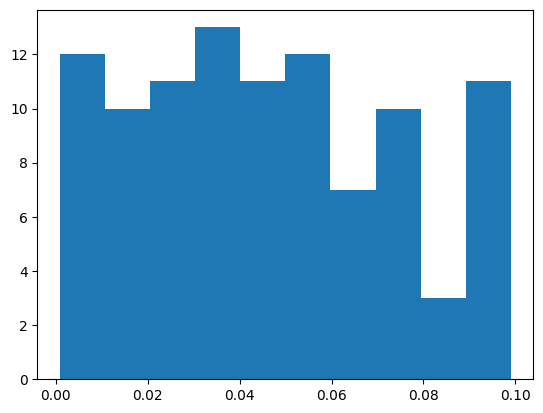

In [23]:
rs_df = pd.read_csv('./data/lc_higgs_rs/lc_higgs_12-13-2024_12:24:57_4292.csv', index_col=0)
y = rs_df['weight_decay']
plt.hist(y)

(array([ 29.,  29., 419., 117., 128., 236., 808., 128.,  81.,  25.]),
 array([46.04704797, 48.625     , 51.20295203, 53.78090406, 56.35885609,
        58.93680812, 61.51476015, 64.09271218, 66.67066421, 69.24861624,
        71.82656827]),
 <BarContainer object of 10 artists>)

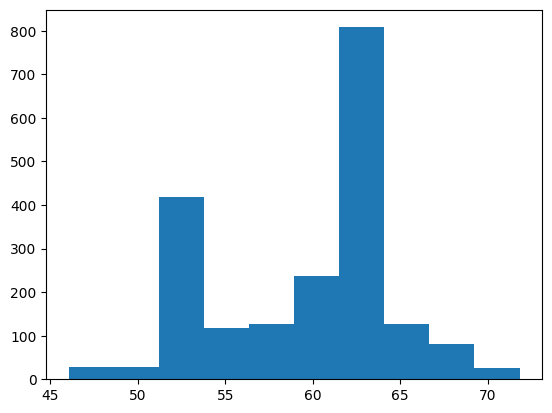

In [19]:
batches = []
for i in range(2000):
    if '50' in list(df['higgs'][0][str(i)].keys()):
        batches.append(df['higgs'][0][str(i)]['50']['results']['1']['final_val_accuracy'])

plt.hist(batches)

In [ ]:
print(list(df['Fashion-MNIST'][0]['0']['50']['config'].keys()))
params = ['num_layers', 'max_units', 'batch_size', 'learning_rate', 'momentum', 'max_dropout', 'weight_decay']

['batch_size', 'imputation_strategy', 'learning_rate_scheduler', 'loss', 'network', 'max_dropout', 'normalization_strategy', 'optimizer', 'cosine_annealing_T_max', 'cosine_annealing_eta_min', 'activation', 'max_units', 'mlp_shape', 'num_layers', 'learning_rate', 'momentum', 'weight_decay']


In [37]:
print(df['Fashion-MNIST'][0]['0']['50']['results'])

{'3': {'model_parameters': 1172276, 'final_train_cross_entropy': 2.065874750044638, 'final_train_accuracy': 43.69549996817517, 'final_train_balanced_accuracy': 0.442178852863913, 'final_val_cross_entropy': 2.035645950693911, 'final_val_accuracy': 52.75875436102856, 'final_val_balanced_accuracy': 0.529315111831486, 'final_test_cross_entropy': 2.268590211868286, 'final_test_accuracy': 54.55411255411256, 'final_test_balanced_accuracy': 0.5372812818026801, 'OpenML_task_id': 189908, 'test_split': 0.33, 'budget': 50, 'seed': 3, 'instances': 70000, 'classes': 10, 'features': 784}, '2': {'model_parameters': 1172276, 'final_train_cross_entropy': 2.120607071477963, 'final_train_accuracy': 41.07631595697282, 'final_train_balanced_accuracy': 0.41625971759637503, 'final_val_cross_entropy': 2.09692013266398, 'final_val_accuracy': 49.993539216953096, 'final_val_balanced_accuracy': 0.5031308046642651, 'final_test_cross_entropy': 2.277302980422973, 'final_test_accuracy': 51.75757575757576, 'final_test_

In [14]:
import h5py
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [25]:
data = h5py.File('./benchmark_data/fcnet_tabular_benchmarks/fcnet_slice_localization_data.hdf5')

In [6]:
k = next(iter(data.keys()))
#k = '{"activation_fn_1": "relu", "activation_fn_2": "tanh", "batch_size": 9, "dropout_1": 0.3, "dropout_2": 0.0, "init_lr": 0.1, "lr_schedule": "cosine", "n_units_1": 341, "n_units_2": 216}'
json.loads(k)

{'activation_fn_1': 'relu',
 'activation_fn_2': 'relu',
 'batch_size': 16,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'init_lr': 0.0005,
 'lr_schedule': 'const',
 'n_units_1': 128,
 'n_units_2': 128}

In [26]:
configs, te, ve = [], [], []
for k in data.keys():
    configs.append(json.loads(k))
    te.append(np.mean(data[k]["final_test_error"]))
    ve.append(np.mean(data[k]["valid_mse"][:, -1]))

dict_data = {key: [d[key] for d in configs] for key in configs[0]}
config_df = pd.DataFrame.from_dict(dict_data)

labels_to_encode = ['lr_schedule', 'activation_fn_1', 'activation_fn_2']
for l in labels_to_encode:
    # Initialize LabelEncoder
    encoder = LabelEncoder()
    # Fit and transform
    config_df[l] = encoder.fit_transform(config_df[l].to_numpy())
config_df['val_error'] = ve
config_df['test_error'] = te

In [7]:
import numpy as np
np.log(1e-5)

-11.512925464970229

In [37]:
X, y = config_df[['activation_fn_1','activation_fn_2', 'batch_size', 'dropout_1', 'dropout_2', 'init_lr', 'lr_schedule', 'n_units_1', 'n_units_2']], config_df['val_error']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R2-score: {r2:.2f}")

R2-score: -1.37


In [25]:
len(configs)

62208

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from spn.algorithms.LearningWrappers import learn_mspn, learn_parametric
from spn.algorithms.EM import EM_optimization
from spn.algorithms.Sampling import sample_instances
from spn.structure.Base import Context, Product, Sum, assign_ids, get_nodes_by_type
from spn.structure.leaves.parametric.Parametric import Categorical, CategoricalDictionary, Gaussian
from spn.structure.StatisticalTypes import MetaType
from spn.algorithms.Inference import log_likelihood
from scipy.interpolate import griddata
import itertools
import numpy as np
from scipy.optimize import minimize

In [156]:

def Loss_func(true_y, pred_y, func_id):
    if func_id == 0:
        # Return the L2 loss.
        return 1./(true_y.shape[0])*np.linalg.norm(true_y-pred_y, 2)

    # Compute the rank loss for varied loss function.
    true_y = np.array(true_y)[:, 0]
    pred_y = np.array(pred_y)[:, 0]
    comb = itertools.combinations(range(true_y.shape[0]), 2)
    pairs = list()
    # Compute the pairs.
    for _, (i, j) in enumerate(comb):
        if true_y[i] > true_y[j]:
            pairs.append((i, j))
        elif true_y[i] < true_y[j]:
            pairs.append((j, i))
    loss = 0.
    pair_num = len(pairs)
    if pair_num == 0:
        return 0.
    for (i, j) in pairs:
        if func_id == 1:
            loss += max(pred_y[j] - pred_y[i], 0.)
        elif func_id == 2:
            loss += np.exp(pred_y[j] - pred_y[i])
        elif func_id == 3:
            loss += np.log(1 + np.exp(pred_y[j] - pred_y[i]))
        elif func_id == 4:
            z = 10 * (pred_y[j] - pred_y[i])
            loss += np.log(1 + np.exp(z))
        else:
            raise ValueError('Invalid loss type!')
    return loss/pair_num


def Loss_der(true_y, A, x, func_id):
    y_pred = A * np.mat(x).T
    if func_id == 0:
        # Return the derivative for L2 loss.
        return -2./(A.shape[0])*np.array(A.T*(true_y-y_pred))[:, 0]

    true_y = np.array(true_y)[:, 0]
    pred_y = np.array(y_pred)[:, 0]

    comb = itertools.combinations(range(true_y.shape[0]), 2)
    pairs = list()
    # Compute the pairs.
    for _, (i, j) in enumerate(comb):
        if true_y[i] > true_y[j]:
            pairs.append((i, j))
        elif true_y[i] < true_y[j]:
            pairs.append((j, i))
    # Calculate the derivatives.
    grad = np.zeros(A.shape[1])
    pair_num = len(pairs)
    if pair_num == 0:
        return grad
    for (i, j) in pairs:
        if func_id == 1:
            if pred_y[j] > pred_y[i]:
                grad += (A[j] - A[i]).A1
        elif func_id == 2:
            grad += np.exp(pred_y[j] - pred_y[i]) * (A[j] - A[i]).A1
        elif func_id == 3:
            e_z = np.exp(pred_y[j] - pred_y[i])
            grad += e_z / (1 + e_z) * (A[j] - A[i]).A1
        elif func_id == 4:
            c = 10.
            e_z = np.exp(c * (pred_y[j] - pred_y[i]))
            grad += e_z / (1 + e_z) * (c * (A[j] - A[i])).A1
        else:
            raise ValueError('Invalid func id!')
    return grad/pair_num


def scipy_solve(A, b, loss_type, debug=False):
    n, m = A.shape

    print(A)
    print(b)

    # Add constraints.
    ineq_cons = {'type': 'ineq',
                 'fun': lambda x: np.array(x),
                 'jac': lambda x: np.eye(len(x))}
    eq_cons = {'type': 'eq',
                 'fun': lambda x: np.array([sum(x) - 1]),
                 'jac': lambda x: np.array([1.]*len(x))}

    x0 = np.array([1. / m] * m)

    def f(x):
        w = np.mat(x).T
        return Loss_func(b, A*w, loss_type)

    def f_der(x):
        return Loss_der(b, A, x, loss_type)

    res = minimize(f, x0, method='SLSQP', jac=f_der,
                   constraints=[eq_cons, ineq_cons],
                   options={'ftol': 1e-8, 'disp': False})

    status = False if np.isnan(res.x).any() else True
    if not res.success and status:
        res.x[res.x < 0.] = 0.
        res.x[res.x > 1.] = 1.
        if sum(res.x) > 1.5:
            status = False

    if debug:
        loss = f(res.x)
        print('Ranking loss', loss)
    return res.x, status

In [112]:
objectives = [lambda x: x**2 + np.random.normal(0, 0.1), lambda x: np.sin(x + 1) + np.random.normal(0, 0.1)]

In [157]:
def get_preds(spn, data, pred_col=-1, repeats=1):
    preds = []
    for i in range(repeats):
        pc_preds = sample_instances(spn, data, np.random.RandomState(i))
        preds.append(pc_preds[:, pred_col].flatten())
    pc_preds = np.array(preds).mean(axis=0)
    return pc_preds

In [181]:
task_domains = [(-4, 4), (-4, 4)]
available_samples = [100, 100]

In [203]:
models = []
for ob, dom, s in zip(objectives, task_domains, available_samples):
    in_x = np.random.uniform(*dom, size=s)
    y_out = ob(in_x)
    data = np.stack((in_x, y_out), axis=1)
    ctxt = Context([MetaType.REAL, MetaType.REAL], parametric_types=[Gaussian, Gaussian])
    ctxt.add_domains(data)
    #spn = learn_parametric(data, ctxt, min_instances_slice=5)
    spn = learn_mspn(data, ctxt, min_instances_slice=3, threshold=0.1)
    models.append(spn)

/home/ml-jseng/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ml-jseng/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ml-jseng/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ml-jseng/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/clus

In [204]:
# build mixture
pred_mat = None
for f, spn in zip(objectives, models):
    x_test = np.random.uniform(-2, 2, size=5).reshape(-1, 1)
    nan_column = np.full((x_test.shape[0], 1), np.nan)
    # Add the NaN column to the original array
    test_data = np.hstack((x_test, nan_column))
    y_pred = get_preds(spn, test_data, repeats=100)
    if pred_mat is not None:
        pred_mat = np.c_[pred_mat, y_pred]
    else:
        pred_mat = y_pred
    y_true = f(x_test)

pred_mat = np.array(pred_mat)
w, status = scipy_solve(np.mat(pred_mat), np.mat(y_true), 4, debug=True)
if status:
    w[w < 1e-3] = 0.
w

[[ 7.7888854   0.72050506]
 [ 7.62654963 -0.04285929]
 [ 1.18436079 -0.03797059]
 [ 7.42832911  0.24627816]
 [ 7.33741923  0.02262482]]
[[ 0.9765241 ]
 [ 0.212889  ]
 [-0.25126287]
 [ 0.67872093]
 [ 0.08663253]]
Ranking loss 0.08842535813804676


array([0.33533336, 0.66466664])

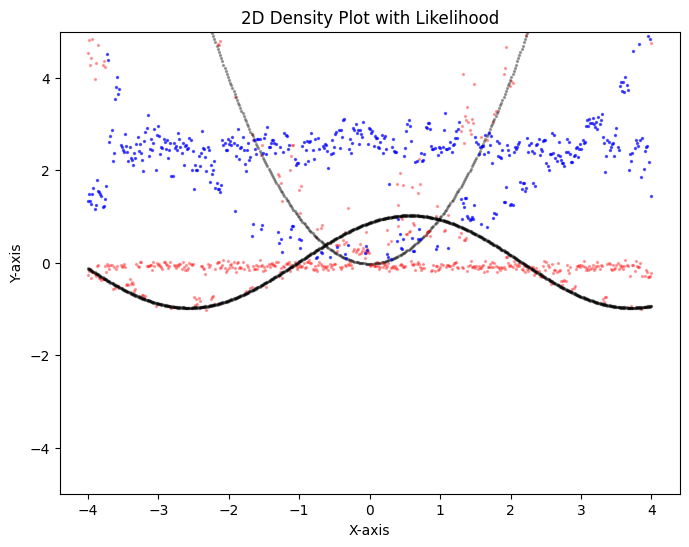

In [205]:
# Example density values from a model (grid data)
# Step 1: Generate 2D points scattered uniformly
n = 10000  # Number of points
x = np.random.uniform(-5, 5, n)  # Uniform x-coordinates in range [-5, 5]
y = np.random.uniform(-5, 5, n)  # Uniform y-coordinates in range [-5, 5]
points = np.column_stack((x, y))  # Shape (n, 2)

plt.figure(figsize=(8, 6))

for i in range(len(objectives) + 1):
# Simulating density values (replace with your model's output)
    if i < len(objectives):
        f = objectives[i]
        spn = models[i]
        pred_col = 'red'
        alpha = 0.3
    else:
        f = objectives[-1]
        pred_col = 'blue'
        alpha = 0.6
    density_values = log_likelihood(spn, points)
    data = np.column_stack((x, y, density_values))  # Shape (n, 3)

    grid_size = 100
    x_edges = np.linspace(x.min(), x.max(), grid_size)
    y_edges = np.linspace(y.min(), y.max(), grid_size)
    X, Y = np.meshgrid(x_edges, y_edges)

    Z = griddata(points[:, :2], density_values, (X, Y), method='linear')

    # get PC preds
    x_test_viz = np.linspace(-4, 4, 500).reshape(-1, 1)
    # Create a column of NaN values
    nan_column = np.full((x_test_viz.shape[0], 1), np.nan)
    # Add the NaN column to the original array
    test_data = np.hstack((x_test_viz, nan_column))
    if i < len(objectives):
        y_pred = get_preds(spn, test_data, repeats=100)
    else:
        pred_mat = []
        for m in models:
            y_pred = get_preds(m, test_data, repeats=100).flatten()
            pred_mat.append(y_pred)
        pred_mat = np.array(pred_mat).T
        y_pred = sum(w[j] * pred_mat[:, j] for j in range(pred_mat.shape[1]))
    y_true_viz = f(x_test_viz)

    # Step 4: Plot the density map
    extent = [x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()]
    #plt.imshow(Z, extent=extent, origin='lower', cmap='viridis', aspect='auto')
    #plt.colorbar(label='Likelihood')  # Add colorbar to show likelihood scale
    #plt.scatter(x, y, c='black', s=1, alpha=0.2, label='Data Points')  # Optional: show data points
    plt.scatter(x_test_viz, y_pred, c=pred_col, alpha=alpha, s=2)
    plt.scatter(x_test_viz, y_true_viz, c='black', alpha=0.3, s=2)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Density Plot with Likelihood')
plt.ylim(-5, 5)
plt.show()

In [206]:
mixture_spn = Sum(w, models)
scope = []
for m in models:
    scope += m.scope
mixture_spn.scope = list(set(scope))
mixture_loss = 0.0
for _ in range(20):
    mixture_spn = assign_ids(mixture_spn)
    nan_column = np.full((x_test.shape[0], 1), np.nan)
    # Add the NaN column to the original array
    test_data = np.hstack((x_test, nan_column))

    y_pred = get_preds(mixture_spn, test_data, repeats=20)
    rank_loss = Loss_func(np.mat(y_true), np.mat(y_pred).T, 4)

    mixture_loss += rank_loss
mixture_loss /= 20

p_pred_mat = []
for m in models:
    m = assign_ids(m)
    y_pred = get_preds(m, test_data, repeats=1).flatten()
    p_pred_mat.append(y_pred)
p_pred_mat = np.array(p_pred_mat).T
y_pred = sum(w[j] * p_pred_mat[:, j] for j in range(p_pred_mat.shape[1]))
p_mixture_loss = Loss_func(np.mat(y_true), np.mat(y_pred).T, 4)

theta = np.array([mixture_loss, p_mixture_loss]) / (mixture_loss + p_mixture_loss)
1 - theta

array([0.58655914, 0.41344086])

In [ ]:
"""
    Sampling strategy.

    1. sample 10 configurations s.t. 50% come from mixture of PCs and 50% are drawn randommly
    2. evaluate those samples
    3. compute predictive mixture and theta based on ranking losses PCs vs. predictive mixture
    4. then, in each iteration use theta choose whether to trust PCs or predictive mixture or current PC.
        4.1. If we trust PC, simply do conditional sampling.
        4.2. If we trust predictive mixture, use EI to get a new suggestion.
        4.3. If we trust current PC, draw conditional samples from it.
"""

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [25]:
files = ['./data/fcnet_slice_rs/fcnet_slice_localization_01-29-2025_16:47:58_4292.csv', './data/fcnet_slice_optunabo/fcnet_slice_localization_01-29-2025_13:41:46_2195.csv']
dfs = []
for f in files:
    df = pd.read_csv(f, index_col=0)
    dfs.append(df)
df = pd.concat(dfs)
df['activation_fn_1'] = LabelEncoder().fit_transform(df['activation_fn_1'])
df['activation_fn_2'] = LabelEncoder().fit_transform(df['activation_fn_2'])
df['lr_schedule'] = LabelEncoder().fit_transform(df['lr_schedule'])

In [26]:
df.head()

,train_performance,val_performance,test_performance,cost,train_loss,val_loss,test_loss,epochs,optim_cost,activation_fn_1,activation_fn_2,batch_size,dropout_1,dropout_2,init_lr,lr_schedule,n_units_1,n_units_2,iter
0,-1.0,-4.110124e+07,-4.110124e+07,NaN,NaN,NaN,NaN,NaN,NaN,1,1,8,0.0,0.3,0.0500,1,64,32,0
1,-1.0,-1.431315e-02,-1.345315e-02,NaN,NaN,NaN,NaN,NaN,NaN,0,0,8,0.3,0.0,0.0010,0,32,16,1
2,-1.0,-4.110124e+07,-4.110124e+07,NaN,NaN,NaN,NaN,NaN,NaN,0,1,16,0.6,0.6,0.0100,1,256,512,2
3,-1.0,-6.042617e-02,-6.232282e-02,NaN,NaN,NaN,NaN,NaN,NaN,0,0,8,0.3,0.3,0.0050,0,16,64,3
4,-1.0,-4.110124e+07,-4.110124e+07,NaN,NaN,NaN,NaN,NaN,NaN,0,0,8,0.6,0.6,0.0005,1,128,256,4


In [27]:
df = df.drop(columns=['iter', 'cost', 'val_loss', 'train_loss', 'test_loss', 'epochs', 'optim_cost'])
df.describe()

,train_performance,val_performance,test_performance,activation_fn_1,activation_fn_2,batch_size,dropout_1,dropout_2,init_lr,lr_schedule,n_units_1,n_units_2
count,2100.0,2.100000e+03,2.100000e+03,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.00000,2100.000000,2100.000000
mean,-1.0,-1.865219e+07,-1.865214e+07,0.497143,0.480952,29.980952,0.285429,0.288143,0.026834,0.45381,179.481905,166.994286
std,0.0,2.046756e+07,2.046761e+07,0.500111,0.499756,21.370473,0.244924,0.247940,0.036327,0.49798,180.080227,171.622002
min,-1.0,-4.110124e+07,-4.110124e+07,0.000000,0.000000,8.000000,0.000000,0.000000,0.000500,0.00000,16.000000,16.000000
25%,-1.0,-4.110124e+07,-4.110124e+07,0.000000,0.000000,16.000000,0.000000,0.000000,0.001000,0.00000,32.000000,32.000000
50%,-1.0,-9.862497e-01,-9.807006e-01,0.000000,0.000000,16.000000,0.300000,0.300000,0.005000,0.00000,128.000000,64.000000
75%,-1.0,-1.164989e-02,-1.117127e-02,1.000000,1.000000,32.000000,0.600000,0.600000,0.050000,1.00000,256.000000,256.000000
max,-1.0,-2.230575e-04,-1.978719e-04,1.000000,1.000000,64.000000,0.600000,0.600000,0.100000,1.00000,512.000000,512.000000


In [28]:
df.head()

,train_performance,val_performance,test_performance,activation_fn_1,activation_fn_2,batch_size,dropout_1,dropout_2,init_lr,lr_schedule,n_units_1,n_units_2
0,-1.0,-4.110124e+07,-4.110124e+07,1,1,8,0.0,0.3,0.0500,1,64,32
1,-1.0,-1.431315e-02,-1.345315e-02,0,0,8,0.3,0.0,0.0010,0,32,16
2,-1.0,-4.110124e+07,-4.110124e+07,0,1,16,0.6,0.6,0.0100,1,256,512
3,-1.0,-6.042617e-02,-6.232282e-02,0,0,8,0.3,0.3,0.0050,0,16,64
4,-1.0,-4.110124e+07,-4.110124e+07,0,0,8,0.6,0.6,0.0005,1,128,256


First 5 rows of the DataFrame:
   train_performance  val_performance  test_performance  activation_fn_1   
0               -1.0    -4.110124e+07     -4.110124e+07                1  \
1               -1.0    -1.431315e-02     -1.345315e-02                0   
2               -1.0    -4.110124e+07     -4.110124e+07                0   
3               -1.0    -6.042617e-02     -6.232282e-02                0   
4               -1.0    -4.110124e+07     -4.110124e+07                0   

   activation_fn_2  batch_size  dropout_1  dropout_2  init_lr  lr_schedule   
0                1           8        0.0        0.3   0.0500            1  \
1                0           8        0.3        0.0   0.0010            0   
2                1          16        0.6        0.6   0.0100            1   
3                0           8        0.3        0.3   0.0050            0   
4                0           8        0.6        0.6   0.0005            1   

   n_units_1  n_units_2  
0         64     

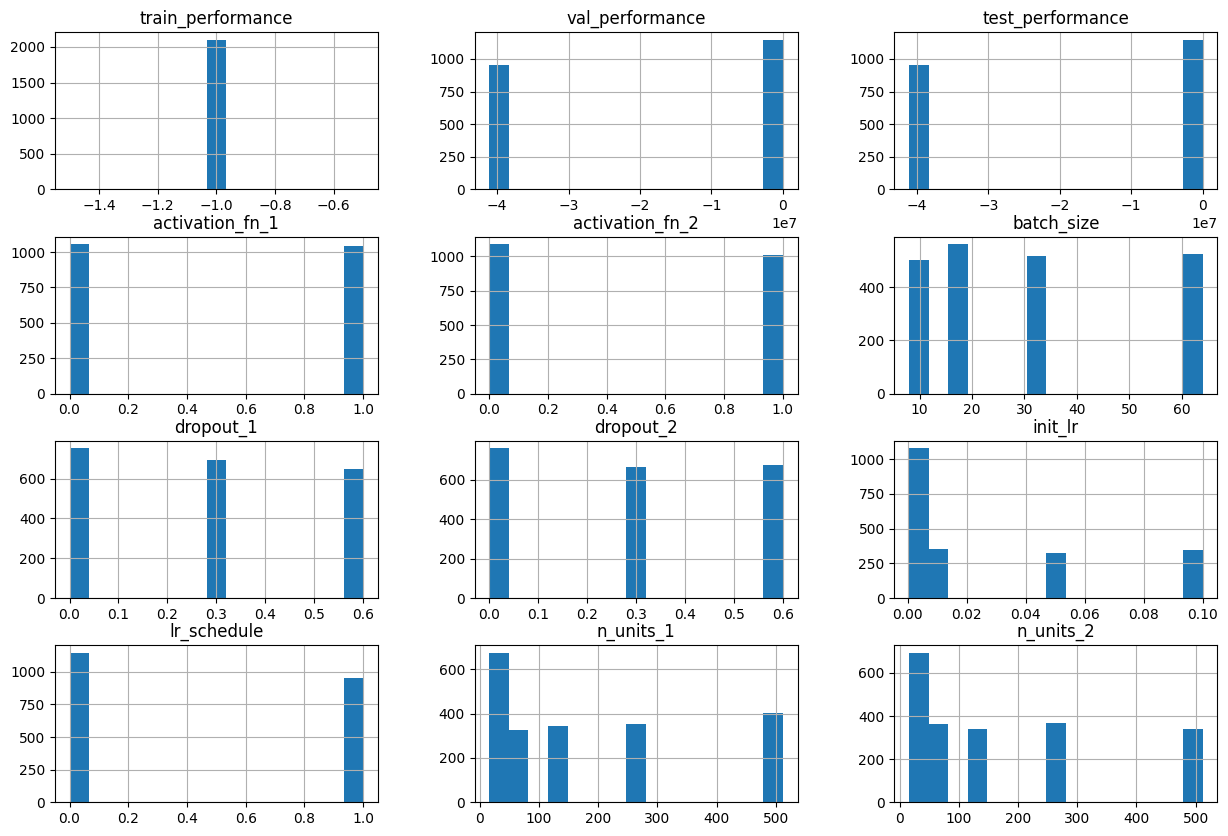


Correlation matrix:
                   train_performance  val_performance  test_performance   
train_performance                NaN              NaN               NaN  \
val_performance                  NaN         1.000000          1.000000   
test_performance                 NaN         1.000000          1.000000   
activation_fn_1                  NaN        -0.011907         -0.011904   
activation_fn_2                  NaN        -0.010818         -0.010820   
batch_size                       NaN        -0.011647         -0.011646   
dropout_1                        NaN        -0.065961         -0.065961   
dropout_2                        NaN        -0.038971         -0.038971   
init_lr                          NaN        -0.016324         -0.016318   
lr_schedule                      NaN        -1.000000         -1.000000   
n_units_1                        NaN         0.029694          0.029698   
n_units_2                        NaN        -0.001469         -0.001464   

   

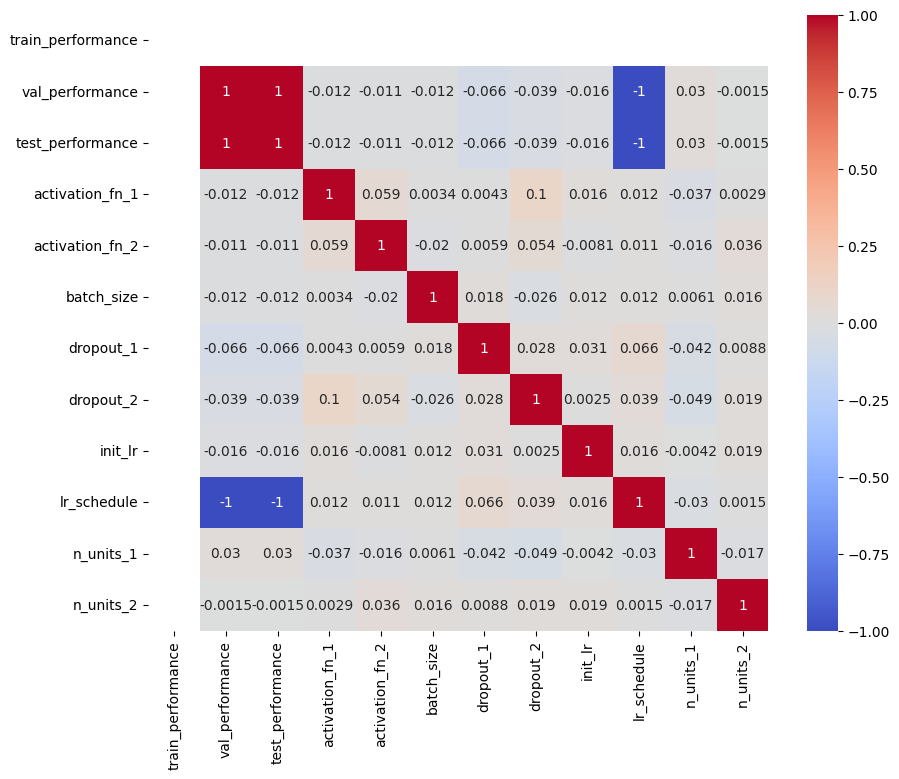

In [30]:
# 1. Display the first few rows of the DataFrame
print("First 5 rows of the DataFrame:")
print(df.head())

# 2. Get a summary of the DataFrame
print("\nSummary of the DataFrame:")
print(df.info())

# 3. Get basic statistics for numerical columns
print("\nBasic statistics for numerical columns:")
print(df.describe())

# 4. Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# 5. Check the distribution of numerical columns
print("\nDistribution of numerical columns:")
df = df[df['test_performance'] <= 0.0003]
df.hist(bins=15, figsize=(15, 10))
plt.show()

# 6. Check the correlation between numerical columns
print("\nCorrelation matrix:")
corr_matrix = df.corr()
print(corr_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# 7. Check the distribution of categorical columns (if any)
categorical_columns = df.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print("\nDistribution of categorical columns:")
    for col in categorical_columns:
        print(f"\nValue counts for {col}:")
        print(df[col].value_counts())
        sns.countplot(y=col, data=df)
        plt.show()

# 8. Pairplot for numerical columns (if dataset is not too large)
if len(df.columns) <= 10:  # Adjust the threshold as needed
    print("\nPairplot for numerical columns:")
    sns.pairplot(df)
    plt.show()

In [31]:
df[df['test_performance'] == df['test_performance'].max()]

,train_performance,val_performance,test_performance,activation_fn_1,activation_fn_2,batch_size,dropout_1,dropout_2,init_lr,lr_schedule,n_units_1,n_units_2
1382,-1.0,-0.000223,-0.000198,0,1,16,0.0,0.0,0.0005,0,128,512


In [8]:
import numpy as np
t = [np.array([1,2,3]), np.array([2,3,4])]
np.stack(t, axis=1)

array([[1, 2],
       [2, 3],
       [3, 4]])